# Florida Coastal Everglades LTER (FCE)

In [1]:
watershed = 'FloridaCoastalEverglades'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

In [52]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,99999), 
                'AirTemperature':(0,50),
                'SolarRadiation':(-10000,10000),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 8),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50),
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

In [5]:
# Data were accessed on 5/4/2020

### 1. Discharge

In [6]:
# Streamflow data from USGS
# USGS 02291000 BARRON RIVER NR EVERGLADES, FLA.
BarronRiver = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=02291000&referred_module=sw&period=&begin_date=1952-02-01&end_date=2014-01-23',
                    header = 0,skiprows = 28 ,parse_dates = True,sep = '\t' ,infer_datetime_format = True)
BarronRiver.head(3)

agency_cd   site_no    datetime 24070_00060_00003 24070_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  02291000  1952-02-01              33.0                    A
2      USGS  02291000  1952-02-02              40.0                    A

In [7]:
prep = copy.deepcopy(BarronRiver.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['24070_00060_00003']))
prep.columns = ['BarronRiver_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(2))
display(prep.tail(2))
BarronRiver = copy.deepcopy(prep)

BarronRiver_Discharge
datetime                         
1952-02-01                   33.0
1952-02-02                   40.0

BarronRiver_Discharge
datetime                         
2014-01-22                   13.2
2014-01-23                   12.6

In [8]:
# Streamflow data from USGS
# USGS 02291001 BARRON RIVER BELOW SR29-3 AT COPELAND, FL
Copeland = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=02291001&referred_module=sw&period=&begin_date=2013-07-16&end_date=2019-12-01',
                    header = 0,skiprows = 28 ,parse_dates = True,sep = '\t' ,infer_datetime_format = True)
Copeland.head(3)

agency_cd   site_no    datetime 24072_00060_00003 24072_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  02291001  2013-07-16              60.1                    A
2      USGS  02291001  2013-07-17              58.8                    A

In [9]:
prep = copy.deepcopy(Copeland.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['24072_00060_00003']))
prep.columns = ['Copeland_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(2))
display(prep.tail(2))
Copeland = copy.deepcopy(prep)

Copeland_Discharge
datetime                      
2013-07-16                60.1
2013-07-17                58.8

Copeland_Discharge
datetime                      
2019-11-30                27.7
2019-12-01                26.8

In [10]:
df_lst = [BarronRiver,Copeland]
for df in df_lst:     
    threC(df,'Discharge') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

BarronRiver_Discharge
datetime                         
1952-02-01                   33.0
1952-02-02                   40.0

(22638, 1)
1952-02-01 00:00:00 2014-01-23 00:00:00


Copeland_Discharge
datetime                      
2013-07-16                60.1
2013-07-17                58.8

(2330, 1)
2013-07-16 00:00:00 2019-12-01 00:00:00
The final table is:


BarronRiver_Discharge Copeland_Discharge
1952-02-01                    33                NaN
1952-02-02                    40                NaN

BarronRiver_Discharge Copeland_Discharge
2019-11-30                   NaN               27.7
2019-12-01                   NaN               26.8

BarronRiver_Discharge
Copeland_Discharge


BarronRiver_Discharge  Copeland_Discharge
1952-02-01                 4414.8                 NaN
1952-02-02                 1132.0                 NaN
1952-02-03                 2999.8                 NaN
1952-02-04                 2575.3                 NaN
1952-02-05                 2660.2                 NaN

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

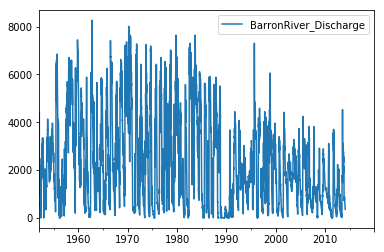

<Figure size 432x288 with 0 Axes>

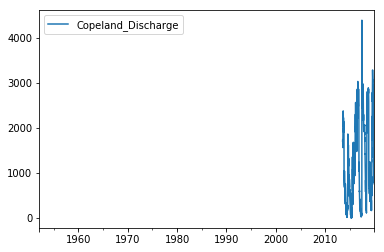

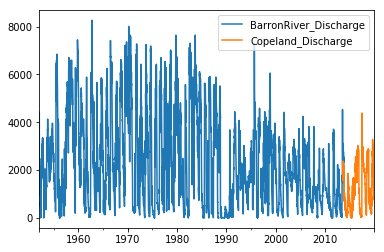

In [11]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]* 28.3 #( to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge')            
Discharge = copy.deepcopy(df)
Discharge.plot()  ###### discharge data seems to be impacted by human activities
Discharge.head() 

## Hydrometeorology Variables

### Read Data

#### 1. NOAA Daily Surface Meteorologic Data at NCDC Flamingo Ranger Station (ID-083020)

In [12]:
# Read meteorology data
Flamingo = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1051.15&entityid=352434dfec96faa0b419380732c10824',
                    parse_dates=True,sep=',',infer_datetime_format=True)
Flamingo.head(3)

LTER_Site   Station      Date  Daily_AirTemp_Mean_C  \
0       FCE  Flamingo  19510101                 13.60   
1       FCE  Flamingo  19510102                 19.45   
2       FCE  Flamingo  19510103                 20.00   

  Flag_Daily_AirTemp_Mean_C  Daily_AirTemp_AbsMax_C  \
0                       NaN                    23.9   
1                       NaN                    22.8   
2                       NaN                    25.0   

  Flag_Daily_AirTemp_AbsMax_C  Daily_AirTemp_AbsMin_C  \
0                         NaN                     3.3   
1                         NaN                    16.1   
2                         NaN                    15.0   

  Flag_Daily_AirTemp_AbsMin_C  Daily_Precip_Total_mm  \
0                         NaN                    0.0   
1                         NaN                    0.0   
2                         NaN                    0.0   

  Flag_Daily_Precip_Total_mm  
0                        NaN  
1                        NaN  
2                        NaN

In [13]:
# Parse the date column, reset the index
Flamingo.index = pd.to_datetime([str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:8] for i in Flamingo['Date']])
Flamingo.index.rename('DateTime', inplace = True)
# Only leave target columns
Flamingo = Flamingo[['Daily_Precip_Total_mm','Daily_AirTemp_Mean_C']]
# Rename the columns
Flamingo.columns = ['Flamingo_Precipitation','Flamingo_AirTemperature']
display(Flamingo.head(2))
Flamingo.tail(2)

Flamingo_Precipitation  Flamingo_AirTemperature
DateTime                                                   
1951-01-01                     0.0                    13.60
1951-01-02                     0.0                    19.45

Flamingo_Precipitation  Flamingo_AirTemperature
DateTime                                                   
2019-11-29                     0.0                    23.05
2019-11-30                     0.0                    23.05

#### 2. NOAA Daily Surface Meteorologic Data at NCDC Everglades Station (ID-082850)

In [14]:
# Read meteorology data
Everglades = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1050.17&entityid=a72ff6e5676167cb598a4ec0c47ce920',
                    parse_dates = True,sep = ',',infer_datetime_format = True)

Everglades.head()

LTER_Site     Station      Date  Daily_AirTemp_Mean_C  \
0       FCE  EVERGLADES  19240201                 24.20   
1       FCE  EVERGLADES  19240202                 17.25   
2       FCE  EVERGLADES  19240203                 13.35   
3       FCE  EVERGLADES  19240204                 17.50   
4       FCE  EVERGLADES  19240205                 22.25   

  Flag_Daily_AirTemp_Mean_C  Daily_AirTemp_AbsMax_C  \
0                       NaN                    26.7   
1                       NaN                    21.7   
2                       NaN                    21.1   
3                       NaN                    23.3   
4                       NaN                    25.6   

  Flag_Daily_AirTemp_AbsMax_C  Daily_AirTemp_AbsMin_C  \
0                         NaN                    21.7   
1                         NaN                    12.8   
2                         NaN                     5.6   
3                         NaN                    11.7   
4                         NaN                    18.9   

  Flag_Daily_AirTemp_AbsMin_C  Daily_Precip_Total_mm  \
0                         NaN                    3.6   
1                         NaN                    0.0   
2                         NaN                    0.0   
3                         NaN                    0.0   
4                         NaN                    0.0   

  Flag_Daily_Precip_Total_mm  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

In [15]:
# Parse the date column, reset the index
Everglades.index = pd.to_datetime([str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:8] for i in Everglades['Date']])
Everglades.index.rename('DateTime', inplace = True)
# Only leave target columns
Everglades = Everglades[['Daily_Precip_Total_mm','Daily_AirTemp_Mean_C']]
# Rename the columns
Everglades.columns = ['Everglades_Precipitation','Everglades_AirTemperature']
display(Everglades.head(2))
Everglades.tail(2)

Everglades_Precipitation  Everglades_AirTemperature
DateTime                                                       
1924-02-01                       3.6                      24.20
1924-02-02                       0.0                      17.25

Everglades_Precipitation  Everglades_AirTemperature
DateTime                                                       
2017-12-30                       0.0                      18.60
2017-12-31                       0.0                      16.65

#### 3. NOAA Daily Surface Meteorologic Data at NCDC Miami International Airport Station (ID-085663)

In [16]:
# Read meteorology data
Miami = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1052.19&entityid=9b66d5e9722194a1a8867558aadec3bc',
                    parse_dates = True,sep = ',',infer_datetime_format = True)

Miami.head()

LTER_Site Station      Date  Daily_AirTemp_Mean_C Flag_Daily_AirTemp_Mean_C  \
0       FCE     MIA  19480101               -9999.0                         M   
1       FCE     MIA  19480102               -9999.0                         M   
2       FCE     MIA  19480103               -9999.0                         M   
3       FCE     MIA  19480104               -9999.0                         M   
4       FCE     MIA  19480105               -9999.0                         M   

   Daily_AirTemp_AbsMax_C Flag_Daily_AirTemp_AbsMax_C  Daily_AirTemp_AbsMin_C  \
0                    27.2                         NaN                    20.6   
1                    27.2                         NaN                    20.6   
2                    22.2                         NaN                    15.6   
3                    22.2                         NaN                    13.9   
4                    18.9                         NaN                     8.9   

  Flag_Daily_AirTemp_AbsMin_C  Daily_Precip_Total_mm  \
0                         NaN                    0.0   
1                         NaN                    3.6   
2                         NaN                    0.0   
3                         NaN                    0.0   
4                         NaN                    0.0   

  Flag_Daily_Precip_Total_mm  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

In [17]:
# Parse the date column, reset the index
Miami.index = pd.to_datetime([str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:8] for i in Miami['Date']])
Miami.index.rename('DateTime', inplace = True)
# Only leave target columns
Miami = Miami[['Daily_Precip_Total_mm','Daily_AirTemp_Mean_C']]
# Rename the columns
Miami.columns = ['Miami_Precipitation','Miami_AirTemperature']
display(Miami.head(2))
Miami.tail(2)

Miami_Precipitation  Miami_AirTemperature
DateTime                                             
1948-01-01                  0.0               -9999.0
1948-01-02                  3.6               -9999.0

Miami_Precipitation  Miami_AirTemperature
DateTime                                             
2020-02-17                  0.0                  24.7
2020-02-18              -9999.0                  24.4

#### 4.NOAA Daily Surface Meteorologic Data at NCDC Royal Palm Ranger Station (ID-087760)

In [18]:
# Read meteorology data
RoyalPalm = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1053.14&entityid=f6ca0adf3bb6ee5d9fa259e4f5a6bcf5',
                    header = 0,skiprows = 0 ,parse_dates = True,sep = ',',infer_datetime_format = True)

RoyalPalm.head()

LTER_Site     Station      Date  Daily_AirTemp_Mean_C  \
0       FCE  RoyalPalmR  19490601                  25.0   
1       FCE  RoyalPalmR  19490602                  25.0   
2       FCE  RoyalPalmR  19490603                  26.1   
3       FCE  RoyalPalmR  19490604                  25.0   
4       FCE  RoyalPalmR  19490605                  24.7   

  Flag_Daily_AirTemp_Mean_C  Daily_AirTemp_AbsMax_C  \
0                       NaN                    31.7   
1                       NaN                    31.1   
2                       NaN                    33.3   
3                       NaN                    31.1   
4                       NaN                    33.3   

  Flag_Daily_AirTemp_AbsMax_C  Daily_AirTemp_AbsMin_C  \
0                         NaN                    18.3   
1                         NaN                    18.9   
2                         NaN                    18.9   
3                         NaN                    18.9   
4                         NaN                    16.1   

  Flag_Daily_AirTemp_AbsMin_C  Daily_Precip_Total_mm  \
0                         NaN                    5.8   
1                         NaN                    9.7   
2                         NaN                    0.8   
3                         NaN                   24.1   
4                         NaN                    0.0   

  Flag_Daily_Precip_Total_mm  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

In [19]:
# Parse the date column, reset the index
RoyalPalm.index = pd.to_datetime([str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:8] for i in RoyalPalm['Date']])
RoyalPalm.index.rename('DateTime', inplace = True)
# Only leave target columns
RoyalPalm = RoyalPalm[['Daily_Precip_Total_mm','Daily_AirTemp_Mean_C']]
# Rename the columns
RoyalPalm.columns = ['RoyalPalm_Precipitation','RoyalPalm_AirTemperature']
display(RoyalPalm.head(2))
RoyalPalm.tail(2)

RoyalPalm_Precipitation  RoyalPalm_AirTemperature
DateTime                                                     
1949-06-01                      5.8                      25.0
1949-06-02                      9.7                      25.0

RoyalPalm_Precipitation  RoyalPalm_AirTemperature
DateTime                                                     
2020-02-04                      0.0                     19.45
2020-02-05                      0.0                     21.95

#### 5. NOAA Daily Surface Meteorologic Data at NCDC Tavernier Station (ID-088841)(FCE), South Florida from June 1936 to May 2009

In [20]:
# Read meteorology data
Tavernier = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1054.3&entityid=76426bf40d3747ea1718516de99b4007',
                   parse_dates = True,sep = ',',infer_datetime_format = True)

Tavernier.head()

LTER_Site    Station      Date  Daily_AirTemp_Mean_C  \
0       FCE  Tavernier  19360601                 -9999   
1       FCE  Tavernier  19360602                 -9999   
2       FCE  Tavernier  19360603                 -9999   
3       FCE  Tavernier  19360604                 -9999   
4       FCE  Tavernier  19360605                 -9999   

  Flag_Daily_AirTemp_Mean_C  Daily_AirTemp_AbsMax_C  \
0                         M                   -9999   
1                         M                   -9999   
2                         M                   -9999   
3                         M                   -9999   
4                         M                      31   

  Flag_Daily_AirTemp_AbsMax_C  Daily_AirTemp_AbsMin_C  \
0                           M                   -9999   
1                           M                   -9999   
2                           M                   -9999   
3                           M                   -9999   
4                         NaN                   -9999   

  Flag_Daily_AirTemp_AbsMin_C  Daily_Precip_Total_mm  \
0                           M                    0.0   
1                           M                    0.0   
2                           M                    0.0   
3                           M                    0.0   
4                           M                   10.2   

  Flag_Daily_Precip_Total_mm  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN

In [21]:
# Parse the date column, reset the index
Tavernier.index = pd.to_datetime([str(i)[:4]+'-'+str(i)[4:6]+'-'+str(i)[6:8] for i in Tavernier['Date']])
Tavernier.index.rename('DateTime', inplace = True)
# Only leave target columns
Tavernier = Tavernier[['Daily_Precip_Total_mm','Daily_AirTemp_Mean_C']]
# Rename the columns
Tavernier.columns = ['Tavernier_Precipitation','Tavernier_AirTemperature']
display(Tavernier.head(2))
Tavernier.tail(2)

Tavernier_Precipitation  Tavernier_AirTemperature
DateTime                                                     
1936-06-01                      0.0                     -9999
1936-06-02                      0.0                     -9999

Tavernier_Precipitation  Tavernier_AirTemperature
DateTime                                                     
2009-05-30                      0.0                     -9999
2009-05-31                      0.0                     -9999

#### 6. Non-continous meteorological data from Butternut Key Weather Tower, Florida Bay, Everglades National Park (FCE LTER)

In [22]:
# Read meteorology data
Butternut = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1141.7&entityid=6bbf4955770f6a45580fefc920a00a21',
                   parse_dates = True,sep = ',',infer_datetime_format = True)

Butternut.head()

SITENAME        Date  Year  Julian_Day  Time  AirTemp  \
0  Butternut_Key_ENP  2001-04-04  2001          94  1730     24.8   
1  Butternut_Key_ENP  2001-04-04  2001          94  1700     24.9   
2  Butternut_Key_ENP  2001-04-04  2001          94  1630     25.0   
3  Butternut_Key_ENP  2001-04-04  2001          94  1600     25.0   
4  Butternut_Key_ENP  2001-04-04  2001          94  1530     25.0   

   RelHumidity   Ws   Wdir  Diff_Volt    Rnet  WaterTemp  
0         68.9  2.6  125.0       71.8 -9999.0    -9999.0  
1         67.2  2.8  152.0       73.0 -9999.0    -9999.0  
2         67.5  3.1  177.0      101.3 -9999.0    -9999.0  
3         69.1  3.0  186.0      109.2 -9999.0    -9999.0  
4         66.3  2.9  152.0      137.7 -9999.0    -9999.0

In [23]:
# Parse the date column, reset the index
Butternut.index = pd.to_datetime(Butternut['Date'])
Butternut.index.rename('DateTime', inplace = True)
# Only leave target columns
Butternut = Butternut[['AirTemp','RelHumidity','Ws','Wdir','Rnet']]
# Rename the columns
Butternut.columns = ['Butternut_AirTemperature','Butternut_RelativeHumidity','Butternut_WindSpeed',
                    'Butternut_WindDirection','Butternut_SolarRadiation_net']
display(Butternut.head(2))
Butternut.tail(2)

Butternut_AirTemperature  Butternut_RelativeHumidity  \
DateTime                                                           
2001-04-04                      24.8                        68.9   
2001-04-04                      24.9                        67.2   

            Butternut_WindSpeed  Butternut_WindDirection  \
DateTime                                                   
2001-04-04                  2.6                    125.0   
2001-04-04                  2.8                    152.0   

            Butternut_SolarRadiation_net  
DateTime                                  
2001-04-04                       -9999.0  
2001-04-04                       -9999.0

Butternut_AirTemperature  Butternut_RelativeHumidity  \
DateTime                                                           
2013-08-13                      28.8                        67.6   
2013-08-13                      28.5                        71.1   

            Butternut_WindSpeed  Butternut_WindDirection  \
DateTime                                                   
2013-08-13                  5.8                    130.0   
2013-08-13                  4.4                    132.0   

            Butternut_SolarRadiation_net  
DateTime                                  
2013-08-13                       -9999.0  
2013-08-13                       -9999.0

#### 7. Non-continuous TS/Ph7b Weather Tower Data, Everglades National Park (FCE LTER) , Taylor River TSPh7b

In [24]:
# Read meteorology data
TaylorRiver = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-fce.1140.5&entityid=9796180c4aab8a045de8d5996ee7faf3',
                    header = 0,skiprows = 0 ,parse_dates = True,sep = ',',infer_datetime_format = True)

TaylorRiver.head(2)

SITENAME        Date   Time  WaterTemp  SoilTemp  AirTemp  RelHumidity  \
0  TS/Ph7b  2008-05-29  15:00      33.72     28.22    31.22        59.72   
1  TS/Ph7b  2008-05-29  15:30      33.74     28.22    30.39        66.13   

     Ws   Wdir  Precipitation  CM3Up_Avg  CM3Dn_Avg  CG3Up_Avg  CG3Dn_Avg  \
0  4.29  299.7            0.0      945.0      74.18     -69.31       6.82   
1  4.04  246.7            0.0      376.0      31.03     -61.05       4.89   

   NetRs_Avg  NetRl_Avg  Albedo  UpTot_Avg  DnTot_Avg  NetTot_Avg  
0      871.0     -76.13    0.08      876.0      81.00       794.5  
1      344.9     -65.94    0.08      314.9      35.92       279.0

In [25]:
# Parse the date column, reset the index
TaylorRiver.index = pd.to_datetime(TaylorRiver['Date'])
TaylorRiver.index.rename('DateTime', inplace = True)
# Only leave target columns
TaylorRiver = TaylorRiver[['SoilTemp','AirTemp','RelHumidity','Ws','Wdir','Precipitation','CM3Up_Avg','NetTot_Avg']]
# Rename the columns
TaylorRiver.columns = ['TaylorRiver_SoilTemperature','TaylorRiver_AirTemperature','TaylorRiver_RelativeHumidity',
                'TaylorRiver_WindSpeed','TaylorRiver_WindDirection','TaylorRiver_Precipitation',
                'TaylorRiver_SolarRadiation_incoming',
                'TaylorRiver_SolarRadiation_net']
display(TaylorRiver.head(2))
TaylorRiver.tail(2)

TaylorRiver_SoilTemperature  TaylorRiver_AirTemperature  \
DateTime                                                              
2008-05-29                        28.22                       31.22   
2008-05-29                        28.22                       30.39   

            TaylorRiver_RelativeHumidity  TaylorRiver_WindSpeed  \
DateTime                                                          
2008-05-29                         59.72                   4.29   
2008-05-29                         66.13                   4.04   

            TaylorRiver_WindDirection  TaylorRiver_Precipitation  \
DateTime                                                           
2008-05-29                      299.7                        0.0   
2008-05-29                      246.7                        0.0   

            TaylorRiver_SolarRadiation_incoming  \
DateTime                                          
2008-05-29                                945.0   
2008-05-29                                376.0   

            TaylorRiver_SolarRadiation_net  
DateTime                                    
2008-05-29                           794.5  
2008-05-29                           279.0

TaylorRiver_SoilTemperature  TaylorRiver_AirTemperature  \
DateTime                                                              
2017-10-16                      -9999.0                       28.71   
2017-10-16                      -9999.0                       28.84   

            TaylorRiver_RelativeHumidity  TaylorRiver_WindSpeed  \
DateTime                                                          
2017-10-16                         79.69                  1.438   
2017-10-16                         78.90                  1.456   

            TaylorRiver_WindDirection  TaylorRiver_Precipitation  \
DateTime                                                           
2017-10-16                      249.5                        0.0   
2017-10-16                      249.9                        0.0   

            TaylorRiver_SolarRadiation_incoming  \
DateTime                                          
2017-10-16                                541.3   
2017-10-16                                287.3   

            TaylorRiver_SolarRadiation_net  
DateTime                                    
2017-10-16                           424.9  
2017-10-16                           203.1

### 2. Precipitation

In [26]:
Flamingo_ppt = Flamingo[['Flamingo_Precipitation']]
Everglades_ppt = Everglades[['Everglades_Precipitation']]
Miami_ppt = Miami[['Miami_Precipitation']]
RoyalPalm_ppt = RoyalPalm[['RoyalPalm_Precipitation']]
Tavernier_ppt= Tavernier[['Tavernier_Precipitation']]
TaylorRiver_ppt = TaylorRiver[['TaylorRiver_Precipitation']]

df_lst = [Flamingo_ppt,Everglades_ppt,Miami_ppt,RoyalPalm_ppt,Tavernier_ppt,TaylorRiver_ppt]
for df in df_lst:     
    threC(df,'Precipitation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

Flamingo_Precipitation
DateTime                          
1951-01-01                     0.0
1951-01-02                     0.0

(24603, 1)
1951-01-01 00:00:00 2019-11-30 00:00:00


Everglades_Precipitation
DateTime                            
1924-02-01                       3.6
1924-02-02                       0.0

(32368, 1)
1924-02-01 00:00:00 2017-12-31 00:00:00


Miami_Precipitation
DateTime                       
1948-01-01                  0.0
1948-01-02                  3.6

(26347, 1)
1948-01-01 00:00:00 2020-02-18 00:00:00


RoyalPalm_Precipitation
DateTime                           
1949-06-01                      5.8
1949-06-02                      9.7

(25284, 1)
1949-06-01 00:00:00 2020-02-05 00:00:00


Tavernier_Precipitation
DateTime                           
1936-06-01                      0.0
1936-06-02                      0.0

(25562, 1)
1936-06-01 00:00:00 2009-05-31 00:00:00


TaylorRiver_Precipitation
DateTime                             
2008-05-29                        0.0
2008-05-29                        0.0

(159788, 1)
2008-05-29 00:00:00 2017-10-16 00:00:00
The final table is:


Flamingo_Precipitation Everglades_Precipitation  \
1924-02-01                    NaN                      3.6   
1924-02-02                    NaN                        0   

           Miami_Precipitation RoyalPalm_Precipitation  \
1924-02-01                 NaN                     NaN   
1924-02-02                 NaN                     NaN   

           Tavernier_Precipitation TaylorRiver_Precipitation  
1924-02-01                     NaN                       NaN  
1924-02-02                     NaN                       NaN

Flamingo_Precipitation Everglades_Precipitation  \
2020-02-17                    NaN                      NaN   
2020-02-18                    NaN                      NaN   

           Miami_Precipitation RoyalPalm_Precipitation  \
2020-02-17                   0                     NaN   
2020-02-18                 NaN                     NaN   

           Tavernier_Precipitation TaylorRiver_Precipitation  
2020-02-17                     NaN                       NaN  
2020-02-18                     NaN                       NaN

Flamingo_Precipitation
Everglades_Precipitation
Miami_Precipitation
RoyalPalm_Precipitation
Tavernier_Precipitation
TaylorRiver_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

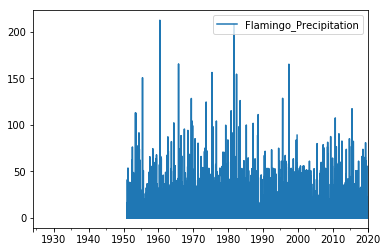

<Figure size 432x288 with 0 Axes>

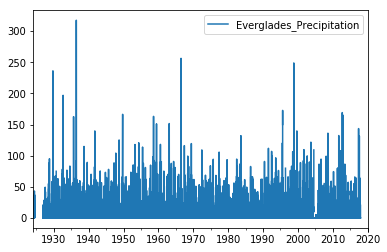

<Figure size 432x288 with 0 Axes>

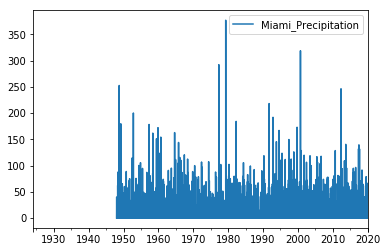

<Figure size 432x288 with 0 Axes>

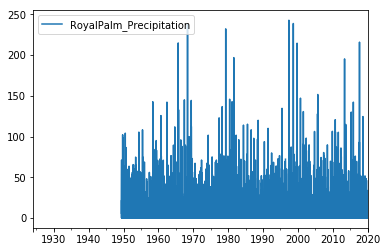

<Figure size 432x288 with 0 Axes>

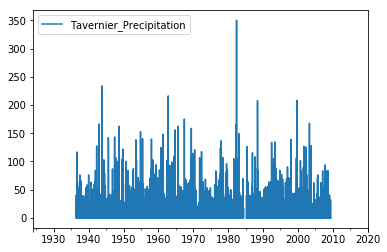

<Figure size 432x288 with 0 Axes>

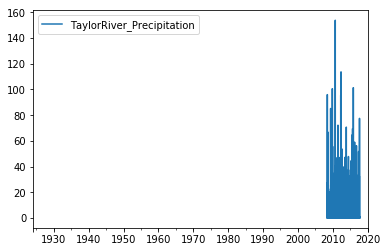

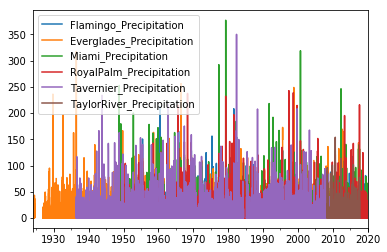

In [27]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'Precipitation')    
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature 

In [53]:
Flamingo_AT = Flamingo[['Flamingo_AirTemperature']]
Everglades_AT = Everglades[['Everglades_AirTemperature']]
Miami_AT = Miami[['Miami_AirTemperature']]
RoyalPalm_AT = RoyalPalm[['RoyalPalm_AirTemperature']]
Tavernier_AT= Tavernier[['Tavernier_AirTemperature']]
#Butternut_AT = Butternut[['Butternut_AirTemperature']]
TaylorRiver_AT = TaylorRiver[['TaylorRiver_AirTemperature']]

df_lst = [Flamingo_AT,Everglades_AT,Miami_AT,RoyalPalm_AT,Tavernier_AT,TaylorRiver_AT]
for df in df_lst:     
    threC(df,'AirTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

Flamingo_AirTemperature
DateTime                           
1951-01-01                    13.60
1951-01-02                    19.45

(24603, 1)
1951-01-01 00:00:00 2019-11-30 00:00:00


Everglades_AirTemperature
DateTime                             
1924-02-01                      24.20
1924-02-02                      17.25

(32368, 1)
1924-02-01 00:00:00 2017-12-31 00:00:00


Miami_AirTemperature
DateTime                        
1948-01-01                   NaN
1948-01-02                   NaN

(26347, 1)
1948-01-01 00:00:00 2020-02-18 00:00:00


RoyalPalm_AirTemperature
DateTime                            
1949-06-01                      25.0
1949-06-02                      25.0

(25284, 1)
1949-06-01 00:00:00 2020-02-05 00:00:00


Tavernier_AirTemperature
DateTime                            
1936-06-01                       NaN
1936-06-02                       NaN

(25562, 1)
1936-06-01 00:00:00 2009-05-31 00:00:00


TaylorRiver_AirTemperature
DateTime                              
2008-05-29                       31.22
2008-05-29                       30.39

(159788, 1)
2008-05-29 00:00:00 2017-10-16 00:00:00
The final table is:


Flamingo_AirTemperature Everglades_AirTemperature  \
1924-02-01                     NaN                      24.2   
1924-02-02                     NaN                     17.25   

           Miami_AirTemperature RoyalPalm_AirTemperature  \
1924-02-01                  NaN                      NaN   
1924-02-02                  NaN                      NaN   

           Tavernier_AirTemperature TaylorRiver_AirTemperature  
1924-02-01                      NaN                        NaN  
1924-02-02                      NaN                        NaN

Flamingo_AirTemperature Everglades_AirTemperature  \
2020-02-17                     NaN                       NaN   
2020-02-18                     NaN                       NaN   

           Miami_AirTemperature RoyalPalm_AirTemperature  \
2020-02-17                 24.7                      NaN   
2020-02-18                 24.4                      NaN   

           Tavernier_AirTemperature TaylorRiver_AirTemperature  
2020-02-17                      NaN                        NaN  
2020-02-18                      NaN                        NaN

Flamingo_AirTemperature
Everglades_AirTemperature
Miami_AirTemperature
RoyalPalm_AirTemperature
Tavernier_AirTemperature
TaylorRiver_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

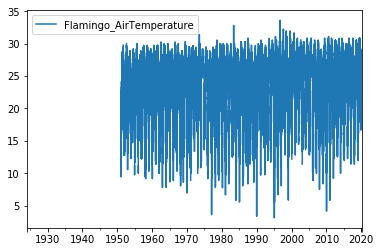

<Figure size 432x288 with 0 Axes>

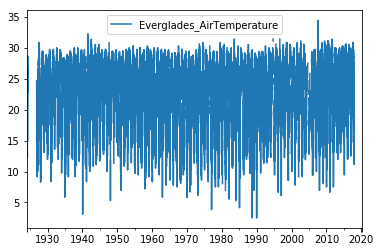

<Figure size 432x288 with 0 Axes>

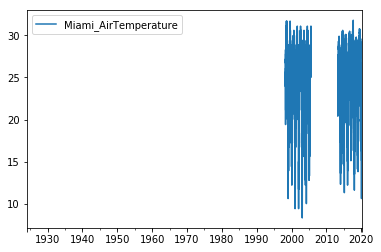

<Figure size 432x288 with 0 Axes>

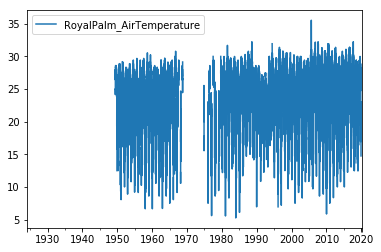

<Figure size 432x288 with 0 Axes>

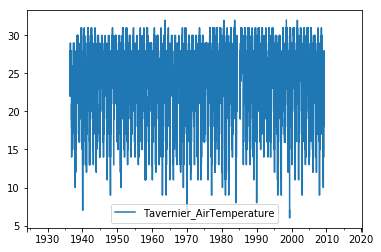

<Figure size 432x288 with 0 Axes>

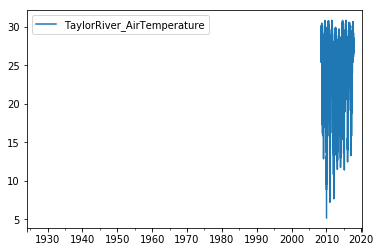

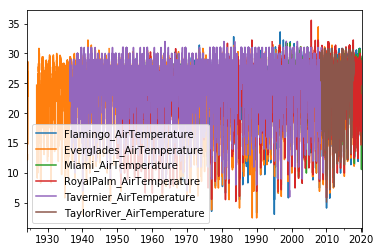

In [54]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! AirTemperature unit should be degree celsius
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'AirTemperature')    
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [32]:
#Butternut_SR = Butternut[['Butternut_SolarRadiation_net']]
TaylorRiver_SR = TaylorRiver[['TaylorRiver_SolarRadiation_incoming','TaylorRiver_SolarRadiation_net']]
prep = aggre_and_comb_daily([TaylorRiver_SR], axis=0, func = "mean") 

The final table is:


TaylorRiver_SolarRadiation_incoming TaylorRiver_SolarRadiation_net
DateTime                                                                     
2008-05-29                             178.591                        93.4617
2008-05-30                             264.338                        187.435

TaylorRiver_SolarRadiation_incoming TaylorRiver_SolarRadiation_net
DateTime                                                                     
2017-10-15                             199.557                        116.586
2017-10-16                             124.273                        53.1233

TaylorRiver_SolarRadiation_incoming
TaylorRiver_SolarRadiation_net


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

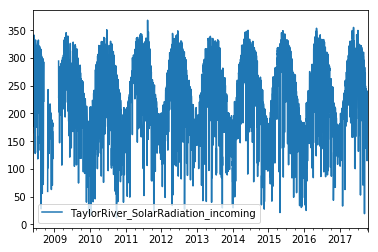

<Figure size 432x288 with 0 Axes>

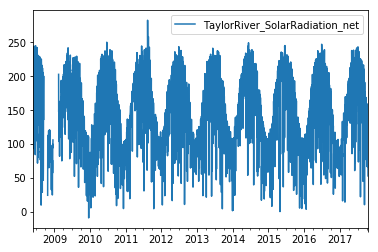

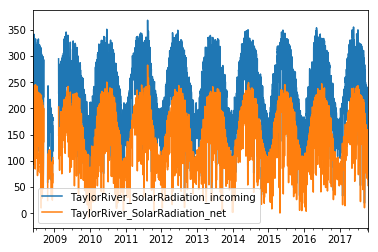

In [33]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation unit should be W/m2
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'SolarRadiation')    
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. RelativeHumidity

In [34]:
TaylorRiver_RH =TaylorRiver[['TaylorRiver_RelativeHumidity']]
prep = aggre_and_comb_daily([TaylorRiver_RH], axis=0, func = "mean") 

The final table is:


TaylorRiver_RelativeHumidity
DateTime                               
2008-05-29                      71.9072
2008-05-30                      78.1279

TaylorRiver_RelativeHumidity
DateTime                               
2017-10-15                      85.3348
2017-10-16                      90.3037

TaylorRiver_RelativeHumidity


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

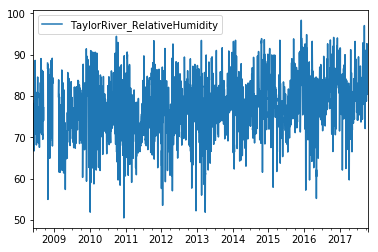

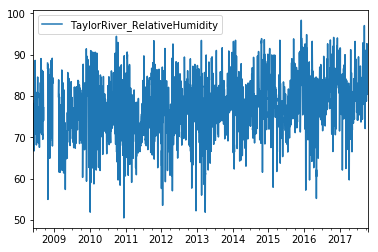

In [35]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'RelativeHumidity')    
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

In [36]:
#Butternut_WD = Butternut[['Butternut_WindDirection']]
TaylorRiver_WD = TaylorRiver[['TaylorRiver_WindDirection']]
df_lst = [TaylorRiver_WD]
prep = aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

The final table is:


TaylorRiver_WindDirection
DateTime                            
2008-05-29                   266.111
2008-05-30                   270.756

TaylorRiver_WindDirection
DateTime                            
2017-10-15                   261.958
2017-10-16                   227.675

TaylorRiver_WindDirection


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

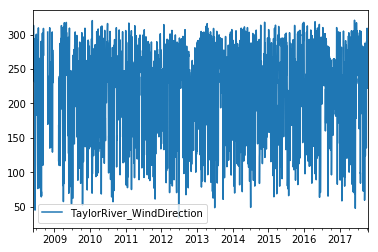

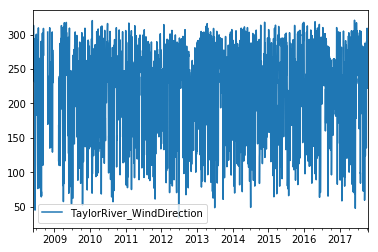

In [37]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindDirection unit should be degree
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'WindDirection')    
WindDirection = copy.deepcopy(df)
WindDirection.plot()

### 7. WindSpeed

In [38]:
#Butternut_WS = Butternut[['Butternut_WindSpeed']]
TaylorRiver_WS = TaylorRiver[['TaylorRiver_WindSpeed']]
df_lst = [TaylorRiver_WS]
for df in df_lst:     
    threC(df,'WindSpeed') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=0, func = "mean") 

TaylorRiver_WindSpeed
DateTime                         
2008-05-29                   4.29
2008-05-29                   4.04

(159788, 1)
2008-05-29 00:00:00 2017-10-16 00:00:00
['TaylorRiver_WindSpeed', datetime.date(2012, 8, 26)]
nan ratio is 0.041666666666666664 , groupby value is 5.333260869565217
The final table is:


TaylorRiver_WindSpeed
DateTime                        
2008-05-29               3.40111
2008-05-30               2.73875

TaylorRiver_WindSpeed
DateTime                        
2017-10-15               1.75642
2017-10-16              0.857708

TaylorRiver_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

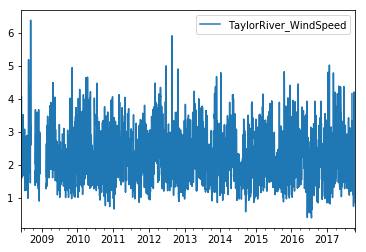

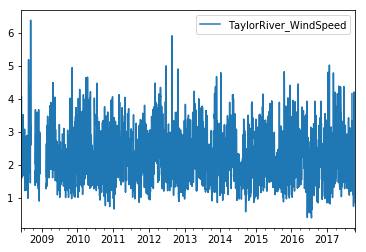

In [39]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'WindSpeed')    
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

In [40]:
### 8. SWE

In [41]:
### 9. SnowDepth

In [42]:
### 10. VaporPressure 

In [43]:
### 11. SoilMoisture

In [44]:
### 12. SoilTemperature

In [45]:
TaylorRiver_ST = TaylorRiver[['TaylorRiver_SoilTemperature']]
df_lst = [TaylorRiver_ST]
for df in df_lst:     
    threC(df,'SoilTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

TaylorRiver_SoilTemperature
DateTime                               
2008-05-29                        28.22
2008-05-29                        28.22

(159788, 1)
2008-05-29 00:00:00 2017-10-16 00:00:00
The final table is:


TaylorRiver_SoilTemperature
2008-05-29                     28.2211
2008-05-30                     28.2638

TaylorRiver_SoilTemperature
2017-10-15                         NaN
2017-10-16                         NaN

TaylorRiver_SoilTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

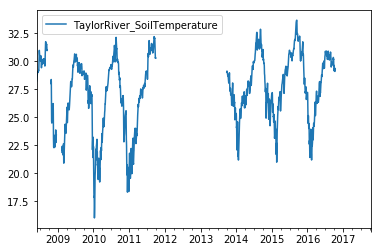

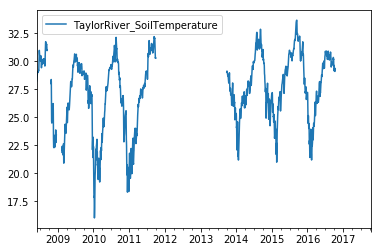

In [46]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'SoilTemperature')    
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()

In [47]:
### 13. Isotope
# https://portal.edirepository.org/nis/mapbrowse?packageid=knb-lter-fce.1067.7

### Combine all data tables

In [55]:
result = pd.concat([Discharge,Precipitation,AirTemperature,
                    SolarRadiation, RelativeHumidity, 
                    WindDirection,WindSpeed, SoilTemperature],
                    axis=1,
                    join='outer')######
result.index.rename('DateTime',inplace = True)
display(result.head())
result.tail()

BarronRiver_Discharge  Copeland_Discharge  Flamingo_Precipitation  \
DateTime                                                                        
1924-02-01                    NaN                 NaN                     0.0   
1924-02-02                    NaN                 NaN                     NaN   
1924-02-03                    NaN                 NaN                     NaN   
1924-02-04                    NaN                 NaN                     NaN   
1924-02-05                    NaN                 NaN                     NaN   

            Everglades_Precipitation  Miami_Precipitation  \
DateTime                                                    
1924-02-01                       0.0                  0.0   
1924-02-02                       0.0                  NaN   
1924-02-03                       0.0                  NaN   
1924-02-04                       0.0                  NaN   
1924-02-05                       0.0                  NaN   

            RoyalPalm_Precipitation  Tavernier_Precipitation  \
DateTime                                                       
1924-02-01                      0.0                      0.0   
1924-02-02                      NaN                      NaN   
1924-02-03                      NaN                      NaN   
1924-02-04                      NaN                      NaN   
1924-02-05                      NaN                      NaN   

            TaylorRiver_Precipitation  Flamingo_AirTemperature  \
DateTime                                                         
1924-02-01                        NaN                    21.15   
1924-02-02                        NaN                      NaN   
1924-02-03                        NaN                      NaN   
1924-02-04                        NaN                      NaN   
1924-02-05                        NaN                      NaN   

            Everglades_AirTemperature  Miami_AirTemperature  \
DateTime                                                      
1924-02-01                      19.40                   NaN   
1924-02-02                      17.25                   NaN   
1924-02-03                      13.35                   NaN   
1924-02-04                      17.50                   NaN   
1924-02-05                      22.25                   NaN   

            RoyalPalm_AirTemperature  Tavernier_AirTemperature  \
DateTime                                                         
1924-02-01                       NaN                      23.0   
1924-02-02                       NaN                       NaN   
1924-02-03                       NaN                       NaN   
1924-02-04                       NaN                       NaN   
1924-02-05                       NaN                       NaN   

            TaylorRiver_AirTemperature  TaylorRiver_SolarRadiation_incoming  \
DateTime                                                                      
1924-02-01                         NaN                                  NaN   
1924-02-02                         NaN                                  NaN   
1924-02-03                         NaN                                  NaN   
1924-02-04                         NaN                                  NaN   
1924-02-05                         NaN                                  NaN   

            TaylorRiver_SolarRadiation_net  TaylorRiver_RelativeHumidity  \
DateTime                                                                   
1924-02-01                             NaN                           NaN   
1924-02-02                             NaN                           NaN   
1924-02-03                             NaN                           NaN   
1924-02-04                             NaN                           NaN   
1924-02-05                             NaN                           NaN   

            TaylorRiver_WindDirection  TaylorRiver_WindSpeed  \
DateTime                                        

BarronRiver_Discharge  Copeland_Discharge  Flamingo_Precipitation  \
DateTime                                                                        
2020-02-14                    NaN                 NaN                     NaN   
2020-02-15                    NaN                 NaN                     NaN   
2020-02-16                    NaN                 NaN                     NaN   
2020-02-17                    NaN                 NaN                     NaN   
2020-02-18                    NaN                 NaN                     NaN   

            Everglades_Precipitation  Miami_Precipitation  \
DateTime                                                    
2020-02-14                       NaN                  0.5   
2020-02-15                       NaN                 14.2   
2020-02-16                       NaN                  8.1   
2020-02-17                       NaN                  0.0   
2020-02-18                       NaN                  NaN   

            RoyalPalm_Precipitation  Tavernier_Precipitation  \
DateTime                                                       
2020-02-14                      NaN                      NaN   
2020-02-15                      NaN                      NaN   
2020-02-16                      NaN                      NaN   
2020-02-17                      NaN                      NaN   
2020-02-18                      NaN                      NaN   

            TaylorRiver_Precipitation  Flamingo_AirTemperature  \
DateTime                                                         
2020-02-14                        NaN                      NaN   
2020-02-15                        NaN                      NaN   
2020-02-16                        NaN                      NaN   
2020-02-17                        NaN                      NaN   
2020-02-18                        NaN                      NaN   

            Everglades_AirTemperature  Miami_AirTemperature  \
DateTime                                                      
2020-02-14                        NaN                  25.8   
2020-02-15                        NaN                  23.4   
2020-02-16                        NaN                  24.4   
2020-02-17                        NaN                  24.7   
2020-02-18                        NaN                  24.4   

            RoyalPalm_AirTemperature  Tavernier_AirTemperature  \
DateTime                                                         
2020-02-14                       NaN                       NaN   
2020-02-15                       NaN                       NaN   
2020-02-16                       NaN                       NaN   
2020-02-17                       NaN                       NaN   
2020-02-18                       NaN                       NaN   

            TaylorRiver_AirTemperature  TaylorRiver_SolarRadiation_incoming  \
DateTime                                                                      
2020-02-14                         NaN                                  NaN   
2020-02-15                         NaN                                  NaN   
2020-02-16                         NaN                                  NaN   
2020-02-17                         NaN                                  NaN   
2020-02-18                         NaN                                  NaN   

            TaylorRiver_SolarRadiation_net  TaylorRiver_RelativeHumidity  \
DateTime                                                                   
2020-02-14                             NaN                           NaN   
2020-02-15                             NaN                           NaN   
2020-02-16                             NaN                           NaN   
2020-02-17                             NaN                           NaN   
2020-02-18                             NaN                           NaN   

            TaylorRiver_WindDirection  TaylorRiver_WindSpeed  \
DateTime                                        

In [56]:
table1=copy.deepcopy(result)
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == result.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


In [57]:
table1.head()

BarronRiver_Discharge  Copeland_Discharge  Flamingo_Precipitation  \
DateTime                                                                        
1924-02-01                    NaN                 NaN                     0.0   
1924-02-02                    NaN                 NaN                     NaN   
1924-02-03                    NaN                 NaN                     NaN   
1924-02-04                    NaN                 NaN                     NaN   
1924-02-05                    NaN                 NaN                     NaN   

            Everglades_Precipitation  Miami_Precipitation  \
DateTime                                                    
1924-02-01                       0.0                  0.0   
1924-02-02                       0.0                  NaN   
1924-02-03                       0.0                  NaN   
1924-02-04                       0.0                  NaN   
1924-02-05                       0.0                  NaN   

            RoyalPalm_Precipitation  Tavernier_Precipitation  \
DateTime                                                       
1924-02-01                      0.0                      0.0   
1924-02-02                      NaN                      NaN   
1924-02-03                      NaN                      NaN   
1924-02-04                      NaN                      NaN   
1924-02-05                      NaN                      NaN   

            TaylorRiver_Precipitation  Flamingo_AirTemperature  \
DateTime                                                         
1924-02-01                        NaN                    21.15   
1924-02-02                        NaN                      NaN   
1924-02-03                        NaN                      NaN   
1924-02-04                        NaN                      NaN   
1924-02-05                        NaN                      NaN   

            Everglades_AirTemperature  Miami_AirTemperature  \
DateTime                                                      
1924-02-01                      19.40                   NaN   
1924-02-02                      17.25                   NaN   
1924-02-03                      13.35                   NaN   
1924-02-04                      17.50                   NaN   
1924-02-05                      22.25                   NaN   

            RoyalPalm_AirTemperature  Tavernier_AirTemperature  \
DateTime                                                         
1924-02-01                       NaN                      23.0   
1924-02-02                       NaN                       NaN   
1924-02-03                       NaN                       NaN   
1924-02-04                       NaN                       NaN   
1924-02-05                       NaN                       NaN   

            TaylorRiver_AirTemperature  TaylorRiver_SolarRadiation_incoming  \
DateTime                                                                      
1924-02-01                         NaN                                  NaN   
1924-02-02                         NaN                                  NaN   
1924-02-03                         NaN                                  NaN   
1924-02-04                         NaN                                  NaN   
1924-02-05                         NaN                                  NaN   

            TaylorRiver_SolarRadiation_net  TaylorRiver_RelativeHumidity  \
DateTime                                                                   
1924-02-01                             NaN                           NaN   
1924-02-02                             NaN                           NaN   
1924-02-03                             NaN                           NaN   
1924-02-04                             NaN                           NaN   
1924-02-05                             NaN                           NaN   

            TaylorRiver_WindDirection  TaylorRiver_WindSpeed  \
DateTime                                        

In [58]:
table1.to_csv('1_' + watershed +'_Download_Aggregation_Daily.csv', sep=',')